# Dev [Part 3 - Multi Motor Simple Quadratic]

In [1]:
%pylab inline
import sys
from ipywidgets import interact

sys.path.append('src')
from motorControl import *
from trajectoryPlanning import *

rc = connect(portName = "/dev/tty.usbserial-A9ETDN3N")

Populating the interactive namespace from numpy and matplotlib


### Initialized Motor Classes

- Really important to initialze these first to restore positions from last session!

In [2]:
#Initialize motor objects for each motor:
vL = Motor(address = 0x81, motorNumber = 2, rc = rc, signFlipped = False, \
           motorCounter = 0, kPID = [1e-2, 1.0])
vR = Motor(address = 0x81, motorNumber = 1, rc = rc, signFlipped = False, \
           motorCounter = 1, kPID = [1e-2, 1.0])
LR = Motor(address = 0x80, motorNumber = 1, rc = rc, signFlipped = False, 
           motorCounter = 2, kPID = [1e-2, 1.0])
FB = Motor(address = 0x80, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 3, kPID = [1e-2, 1.0])
yaw = Motor(address = 0x82, motorNumber = 2, rc = rc, signFlipped = False, \
            motorCounter = 4, kPID = [1e-2, 1.0])
pitch = Motor(address = 0x82, motorNumber = 1, rc = rc, signFlipped = False, \
              motorCounter = 5, kPID = [1e-2, 1.0])

#Keep in a nice motor list:
motors = [vL, vR, LR, FB, yaw, pitch]

In [7]:
savePositions(motors)
getPositions(motors)

[-15430, -9791, 53468, 35987, 8414, 7413]

In [20]:
interact(manualControl, leftUD = (-50, 50), rightUD = (-50, 50), leftRight = (-50, 50), \
         fB = (-50, 50), tilt = (-50, 50), pan = (-50, 50))

<function motorControl.manualControl>

In [21]:
stopAll(rc)
savePositions(motors)
getPositions(motors)

[-20321, -4908, 53468, -10463, 8414, 7413]

In [8]:
startingPositions = getPositions(motors)
print startingPositions

[-15430, -9791, 53468, 35987, 8414, 7413]


In [9]:
verticalDelta = -5000

In [10]:
targetPositions = copy(startingPositions)

In [11]:
targetPositions[0] = targetPositions[0] + verticalDelta
targetPositions[1] = targetPositions[1] - verticalDelta

targetPositions

array([-20430,  -4791,  53468,  35987,   8414,   7413])

In [12]:
tolerance = 100.0 #Anything less than this many ticks we're calling "Not a move"

motorsToMove = []
targetPositionsToMove = []
for i, motor in enumerate(motors):
    if abs(motor.getPosition()-targetPositions[i]) > tolerance:
        motorsToMove.append(motor)
        targetPositionsToMove.append(targetPositions[i])

In [13]:
targetPositionsToMove

[-20430, -4791]

In [14]:
totalTime = 10.0
rampTime = 2.0
lookAheadTime = 1.0

trajectories = []
for i, motor in enumerate(motorsToMove):
    trajectories.append(SimpleQuadraticTrajectory(tu = rampTime, tt = totalTime, \
                                            p1 = motor.getPosition(), p2 = targetPositions[i]))

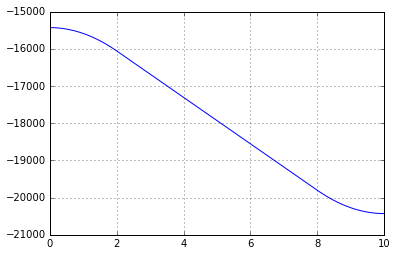

In [15]:
trajectories[0].visualize()

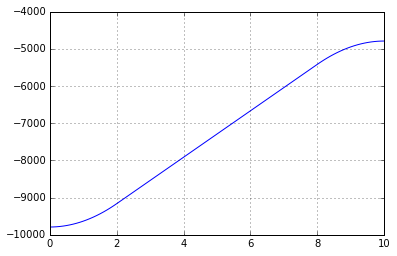

In [16]:
trajectories[1].visualize()

In [17]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -2500.0, targetVelocityMax = 2500.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    
    for i, motor in enumerate(motorsToMove):
        lookAheadValue = trajectories[i].compute(timeElapsed + lookAheadTime)
        motor.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)

stopAll(rc)
savePositions(motors)
print getPositions(motors), targetPositions

[-20321, -4908, 53468, 35987, 8414, 7413] [-20430  -4791  53468  35987   8414   7413]


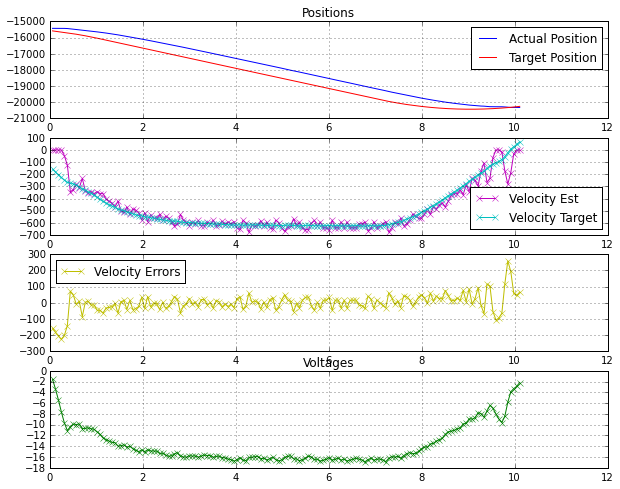

In [18]:
motorsToMove[0].visualizeMove()

### Ok, so now the game is wrapping things up into a nice, consistent, repeatable workflow!

- Make an "absolute" zero that makes sense, reset encoders and save!
    - maybe even make a "goHome" method or something. 
    - This will be our first stored "absolute way point"
    - I think home should be a position that is as repeatable as possible, and out of th eway, maybe far back in up righ corner. I'll take a picture, and put it in the repository. Oooh, and I need to check the levelness of the horizontal beam for this point!
    - It's that's home, then one of my positions should "centered", that is directly overhead, looking straight down. These will be my first two absolute positions. 
- From there, I wanto to be able to create, save, and name new absolute positions using the manual control sliders. 
- Finally, I want a nice, wrapped up way of of moving between positions!
- That should be all I need to HTS 1. 
- Next time I work on motion rig - "keep the camera looking at the same thing" code. That will be fun!

### Let's start with Multi- Axis "synchronized" move. 

In [37]:
startingPositions = getPositions(motors)
targetPositions = copy(startingPositions)

verticalDelta = 12000
targetPositions[0] = targetPositions[0] + verticalDelta
targetPositions[1] = targetPositions[1] - verticalDelta
targetPositions[3] = targetPositions[3] + 8000
targetPositions[5] = targetPositions[5] - 3000

In [38]:
print startingPositions, targetPositions

[-12366, -12842, 53468, -6504, 8125, 7413] [  -366 -24842  53468   1496   8125   4413]


Somethign I did last time that I think was smart was mad a trunkated "motors to move" list. 

In [39]:
tolerance = 100.0 #Anything less than this many ticks we're calling "Not a move"

motorsToMove = []
targetPositionsToMove = []
for i, motor in enumerate(motors):
    if abs(motor.getPosition()-targetPositions[i]) > tolerance:
        motorsToMove.append(motor)
        targetPositionsToMove.append(targetPositions[i])

In [40]:
targetPositionsToMove

[-366, -24842, 1496, 4413]

In [41]:
totalTime = 20.0
rampTime = 4.0
lookAheadTime = 1.0

trajectories = []
for i, motor in enumerate(motorsToMove):
    trajectories.append(SimpleQuadraticTrajectory(tu = rampTime, tt = totalTime, \
                                            p1 = motor.getPosition(), p2 = targetPositionsToMove[i]))

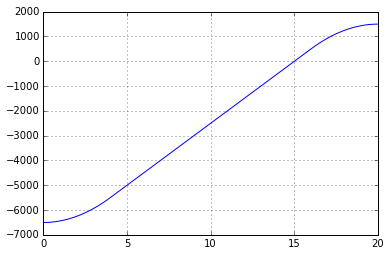

In [42]:
trajectories[2].visualize()

In [43]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -2500.0, targetVelocityMax = 2500.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    
    for i, motor in enumerate(motorsToMove):
        lookAheadValue = trajectories[i].compute(timeElapsed + lookAheadTime)
        motor.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)

stopAll(rc)
savePositions(motors)
print getPositions(motors), targetPositions
print getPositions(motors) - targetPositions

[-416, -24779, 53468, 1458, 8125, 4406] [  -366 -24842  53468   1496   8125   4413]
[-50  63   0 -38   0  -7]


In [44]:
print getPositions(motors) - targetPositions

[-50  63   0 -38   0  -7]


In [45]:
stopAll(rc)

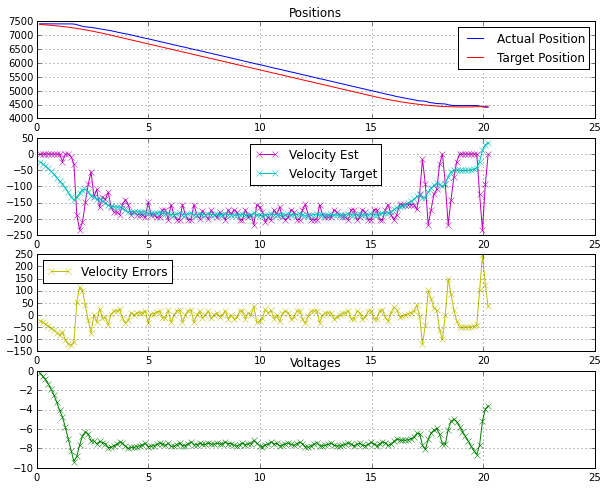

In [48]:
motorsToMove[3].visualizeMove()